In [1]:
# importing the necessary libraries
import os
import requests
import pandas as pd
import numpy as np
import pickle
import json

In [5]:
# read the city bikes csv file
df_city_bikes = pd.read_csv('df_city_bikes.csv')

In [7]:
df_city_bikes.head()

,Unnamed: 0,Station Name,Latitude,Longitude,Available Bikes
0,0,Chilco & Barclay,49.291909,-123.140713,12
1,1,St George & Broadway,49.262321,-123.093060,2
2,2,Britannia Parking Lot,49.275882,-123.071865,2
3,3,Morton & Denman,49.288030,-123.142135,9
4,4,Thornton & National,49.273777,-123.092723,2


In [9]:
# get the api keys as environmenet variables

fsq_api_key = os.environ['FOURSQUARE_API_KEY']
yelp_api_key = os.environ['YELP_API_KEY']


In [17]:
idx = print(df_city_bikes.index)

RangeIndex(start=0, stop=258, step=1)


# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [22]:
# check teh length of stations
N_stations = len(df_city_bikes)

In [24]:
N_stations

258

In [28]:
# define the parameters
radius = 1000
limit = 50
categories = 'restaurant, park,16032,19046,19047,18000'
idx = 7

url_foursquare = "https://api.foursquare.com/v3/places/search"

headers = {
    "accept": "application/json",
    "Authorization": fsq_api_key
}

In [30]:
# loop through each row
df_results_all = []

for idx in range(258):

    lat = df_city_bikes['latitude'].iloc[idx]
    lng = df_city_bikes['longitude'].iloc[idx]
    ll = f"{lat},{lng}"

    params = {
        'radius': radius,
        'categories': categories,
        'll': ll,
        'limit': limit
    }


    response = requests.get(url_foursquare, headers=headers, params=params)

    results = response.json()

    

In [140]:
# results

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [34]:
results.keys()

dict_keys(['results', 'context'])

Put your parsed results into a DataFrame

In [84]:
df_results = pd.json_normalize(results['results'])
# create a new column
df_results['bike_station_index'] = idx

df_results_all.append(df_results)

In [38]:
df_results.head()

,fsq_id,categories,chains,closed_bucket,distance,link,name,timezone,geocodes.main.latitude,geocodes.main.longitude,...,location.cross_street,location.formatted_address,location.locality,location.region,location.postcode,geocodes.drop_off.latitude,geocodes.drop_off.longitude,related_places.children,location.address_extended,bike_station_index
0,50f1dd8ee4b0ee8fd93bbfff,"[{'id': 10047, 'name': 'Public Art', 'short_na...",[],VeryLikelyOpen,84,/v3/places/50f1dd8ee4b0ee8fd93bbfff,Dude Chilling Park,America/Vancouver,49.263472,-123.096107,...,at Guelph Park,"400 E 8th Ave (at Guelph Park), Vancouver BC",Vancouver,BC,NaN,NaN,NaN,NaN,NaN,257
1,57859a88498ee75da193d5c7,"[{'id': 13049, 'name': 'Diner', 'short_name': ...",[],LikelyOpen,438,/v3/places/57859a88498ee75da193d5c7,Fable Diner,America/Vancouver,49.263042,-123.101505,...,Main,"151 Broadway E (Main), Vancouver BC V5T 1W1",Vancouver,BC,V5T 1W1,NaN,NaN,NaN,NaN,257
2,4f74d86fe4b0e7e85a1bfd18,"[{'id': 18021, 'name': 'Gym and Studio', 'shor...",[],LikelyOpen,617,/v3/places/4f74d86fe4b0e7e85a1bfd18,The Hive Bouldering Gym,America/Vancouver,49.268692,-123.092576,...,,"520 Industrial Ave, Vancouver BC V6A 2P3",Vancouver,BC,V6A 2P3,49.268947,-123.092533,[],NaN,257
3,4f2c7acce4b0c1a817bf4336,"[{'id': 18028, 'name': 'Yoga Studio', 'short_n...",[],LikelyOpen,745,/v3/places/4f2c7acce4b0c1a817bf4336,Moksha Yoga East Vancouver,America/Vancouver,49.257137,-123.092486,...,,"560 15th Ave E, Vancouver BC V5T 2R5",Vancouver,BC,V5T 2R5,NaN,NaN,NaN,NaN,257
4,4b2d2fcef964a5207bd024e3,"[{'id': 12080, 'name': 'Library', 'short_name'...",[],LikelyOpen,342,/v3/places/4b2d2fcef964a5207bd024e3,Mount Pleasant Community Centre,America/Vancouver,49.264143,-123.100139,...,Main Street,"1 Kingsway (Main Street), Vancouver BC V5T 3H7",Vancouver,BC,V5T 3H7,49.264096,-123.100501,NaN,NaN,257


In [40]:
# create union using concat
df_results_all = pd.concat(df_results_all)

In [44]:
# df_results_all.reset_index()

In [46]:
df_results_all.shape

(50, 24)

In [136]:
# df_results_all[['categories', 'bike_station_index']]

In [50]:
df_results.columns # see columns 

Index(['fsq_id', 'categories', 'chains', 'closed_bucket', 'distance', 'link',
       'name', 'timezone', 'geocodes.main.latitude', 'geocodes.main.longitude',
       'geocodes.roof.latitude', 'geocodes.roof.longitude', 'location.address',
       'location.country', 'location.cross_street',
       'location.formatted_address', 'location.locality', 'location.region',
       'location.postcode', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'related_places.children',
       'location.address_extended', 'bike_station_index'],
      dtype='object')

In [52]:
df_joined = pd.merge(df_results_all,df_city_bikes,left_on='bike_station_index',right_on=df_city_bikes.index)

In [54]:
df_joined.head()

,fsq_id,categories,chains,closed_bucket,distance,link,name_x,timezone,geocodes.main.latitude,geocodes.main.longitude,...,free_bikes,empty_slots,extra.uid,extra.renting,extra.returning,extra.last_updated,extra.slots,extra.normal_bikes,extra.ebikes,extra.has_ebikes
0,50f1dd8ee4b0ee8fd93bbfff,"[{'id': 10047, 'name': 'Public Art', 'short_na...",[],VeryLikelyOpen,84,/v3/places/50f1dd8ee4b0ee8fd93bbfff,Dude Chilling Park,America/Vancouver,49.263472,-123.096107,...,8,10,262,True,True,1739001737,18,7,1,True
1,57859a88498ee75da193d5c7,"[{'id': 13049, 'name': 'Diner', 'short_name': ...",[],LikelyOpen,438,/v3/places/57859a88498ee75da193d5c7,Fable Diner,America/Vancouver,49.263042,-123.101505,...,8,10,262,True,True,1739001737,18,7,1,True
2,4f74d86fe4b0e7e85a1bfd18,"[{'id': 18021, 'name': 'Gym and Studio', 'shor...",[],LikelyOpen,617,/v3/places/4f74d86fe4b0e7e85a1bfd18,The Hive Bouldering Gym,America/Vancouver,49.268692,-123.092576,...,8,10,262,True,True,1739001737,18,7,1,True
3,4f2c7acce4b0c1a817bf4336,"[{'id': 18028, 'name': 'Yoga Studio', 'short_n...",[],LikelyOpen,745,/v3/places/4f2c7acce4b0c1a817bf4336,Moksha Yoga East Vancouver,America/Vancouver,49.257137,-123.092486,...,8,10,262,True,True,1739001737,18,7,1,True
4,4b2d2fcef964a5207bd024e3,"[{'id': 12080, 'name': 'Library', 'short_name'...",[],LikelyOpen,342,/v3/places/4b2d2fcef964a5207bd024e3,Mount Pleasant Community Centre,America/Vancouver,49.264143,-123.100139,...,8,10,262,True,True,1739001737,18,7,1,True


In [56]:
df_joined.shape

(50, 40)

In [293]:
df_joined.to_csv('city_bike_share.csv')

# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [263]:
radius = 1000
limit = 20
categories = "restaurants,cafes,bars,parks"
idx = 7

url_yelp = "https://api.yelp.com/v3/businesses/search"

headers_yelp = {
    "accept": "application/json",
    "authorization": "Bearer " + yelp_api_key
}


In [265]:
df_results_all_yelp = []

for i in df_city_bikes:

    latitude = df_city_bikes['latitude'].iloc[idx]
    longitude = df_city_bikes['longitude'].iloc[idx]
    # ll = f"{lat},{lng}"

    params_yelp = {
        'radius': radius,
        'categories': categories,
        'latitude': latitude,
        'longitude': longitude,
        'limit': limit
    }


    response_yelp = requests.get(url_yelp, headers=headers_yelp, params=params_yelp)

    results_yelp = response_yelp.json()

    

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [267]:
# view the json result
results_yelp

{'businesses': [{'id': 'p5thThuUITUjAy8gS3sPMw',
   'alias': 'fable-kitchen-vancouver-2',
   'name': 'Fable Kitchen',
   'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/mIfjavZhuvotp9enRH7hUA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/fable-kitchen-vancouver-2?adjust_creative=nWThp1CqaJAmGmH9GF3RxQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=nWThp1CqaJAmGmH9GF3RxQ',
   'review_count': 805,
   'categories': [{'alias': 'newcanadian', 'title': 'Canadian (New)'}],
   'rating': 4.3,
   'coordinates': {'latitude': 49.2679331, 'longitude': -123.149019},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '1944 W 4th Avenue',
    'address2': '',
    'address3': '',
    'city': 'Vancouver',
    'zip_code': 'V6J 1M5',
    'country': 'CA',
    'state': 'BC',
    'display_address': ['1944 W 4th Avenue',
     'Vancouver, BC V6J 1M5',
     'Canada']},
   'phone': '+16047321322',
   'display_phone': '+1 604-732-1322',
   'distan

In [269]:
# view the keys in the result
results_yelp.keys()

dict_keys(['businesses', 'total', 'region'])

In [177]:
results_yelp['total']

247

Put your parsed results into a DataFrame

In [271]:
# convert to dataframe
df_results_yelp = pd.json_normalize(results_yelp['businesses'])
df_results_yelp['bike_station_index'] = idx
# append this to the empty list
df_results_all_yelp.append(df_results_yelp)

In [273]:
df_results_yelp.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.city,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.menu_url,attributes.open24_hours,attributes.waitlist_reservation,bike_station_index
0,p5thThuUITUjAy8gS3sPMw,fable-kitchen-vancouver-2,Fable Kitchen,https://s3-media3.fl.yelpcdn.com/bphoto/mIfjav...,False,https://www.yelp.com/biz/fable-kitchen-vancouv...,805,"[{'alias': 'newcanadian', 'title': 'Canadian (...",4.3,[],...,Vancouver,V6J 1M5,CA,BC,"[1944 W 4th Avenue, Vancouver, BC V6J 1M5, Can...",None,http://qrco.de/fabledinner,None,None,7
1,EvVCF3mompCg3PPkpqip2A,mr-red-cafe-vancouver-3,Mr. Red Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/jJyqdQ...,False,https://www.yelp.com/biz/mr-red-cafe-vancouver...,128,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.8,[],...,Vancouver,V6K 2G3,CA,BC,"[2680 W Broadway, Vancouver, BC V6K 2G3, Canada]",None,,None,None,7
2,ULnAJdHecyxXcKnDgi6_iA,banana-leaf-vancouver-6,Banana Leaf,https://s3-media3.fl.yelpcdn.com/bphoto/3t_1kE...,False,https://www.yelp.com/biz/banana-leaf-vancouver...,182,"[{'alias': 'malaysian', 'title': 'Malaysian'},...",3.6,[],...,Vancouver,V6K 2G9,CA,BC,"[3005 W Broadway, Vancouver, BC V6K 2G9, Canada]",None,None,None,None,7
3,9R4vBq3BUYom9geOTiFs0w,east-is-east-vancouver,East Is East,https://s3-media4.fl.yelpcdn.com/bphoto/_uWz1o...,False,https://www.yelp.com/biz/east-is-east-vancouve...,320,"[{'alias': 'mideastern', 'title': 'Middle East...",3.9,[],...,Vancouver,V6K 2H5,CA,BC,"[3035 west Broadway, Vancouver, BC V6K 2H5, Ca...",None,http://www.eastiseast.ca/menu.html,None,None,7
4,zkib99WfL5VCu7Za5hG6Fw,pho-japolo-vancouver,Pho Japolo,https://s3-media3.fl.yelpcdn.com/bphoto/s1O4J2...,False,https://www.yelp.com/biz/pho-japolo-vancouver?...,67,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.9,[],...,Vancouver,V6K 2G6,CA,BC,"[2807 W Broadway, Vancouver, BC V6K 2G6, Canada]",None,https://www.phojapolo.com/other-locations-food...,None,None,7


In [275]:
# concat the results
df_results_all_yelp = pd.concat(df_results_all_yelp)

In [279]:
df_results_all_yelp.reset_index()

,index,id,alias,name,image_url,is_closed,url,review_count,categories,rating,...,location.city,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.menu_url,attributes.open24_hours,attributes.waitlist_reservation,bike_station_index
0,0,p5thThuUITUjAy8gS3sPMw,fable-kitchen-vancouver-2,Fable Kitchen,https://s3-media3.fl.yelpcdn.com/bphoto/mIfjav...,False,https://www.yelp.com/biz/fable-kitchen-vancouv...,805,"[{'alias': 'newcanadian', 'title': 'Canadian (...",4.3,...,Vancouver,V6J 1M5,CA,BC,"[1944 W 4th Avenue, Vancouver, BC V6J 1M5, Can...",None,http://qrco.de/fabledinner,None,None,7
1,1,EvVCF3mompCg3PPkpqip2A,mr-red-cafe-vancouver-3,Mr. Red Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/jJyqdQ...,False,https://www.yelp.com/biz/mr-red-cafe-vancouver...,128,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.8,...,Vancouver,V6K 2G3,CA,BC,"[2680 W Broadway, Vancouver, BC V6K 2G3, Canada]",None,,None,None,7
2,2,ULnAJdHecyxXcKnDgi6_iA,banana-leaf-vancouver-6,Banana Leaf,https://s3-media3.fl.yelpcdn.com/bphoto/3t_1kE...,False,https://www.yelp.com/biz/banana-leaf-vancouver...,182,"[{'alias': 'malaysian', 'title': 'Malaysian'},...",3.6,...,Vancouver,V6K 2G9,CA,BC,"[3005 W Broadway, Vancouver, BC V6K 2G9, Canada]",None,None,None,None,7
3,3,9R4vBq3BUYom9geOTiFs0w,east-is-east-vancouver,East Is East,https://s3-media4.fl.yelpcdn.com/bphoto/_uWz1o...,False,https://www.yelp.com/biz/east-is-east-vancouve...,320,"[{'alias': 'mideastern', 'title': 'Middle East...",3.9,...,Vancouver,V6K 2H5,CA,BC,"[3035 west Broadway, Vancouver, BC V6K 2H5, Ca...",None,http://www.eastiseast.ca/menu.html,None,None,7
4,4,zkib99WfL5VCu7Za5hG6Fw,pho-japolo-vancouver,Pho Japolo,https://s3-media3.fl.yelpcdn.com/bphoto/s1O4J2...,False,https://www.yelp.com/biz/pho-japolo-vancouver?...,67,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.9,...,Vancouver,V6K 2G6,CA,BC,"[2807 W Broadway, Vancouver, BC V6K 2G6, Canada]",None,https://www.phojapolo.com/other-locations-food...,None,None,7
5,5,OCgVYVtbOrTgR5pORFUVPw,chewies-chicken-and-biscuits-vancouver,Chewie's Chicken & Biscuits,https://s3-media1.fl.yelpcdn.com/bphoto/0iQmXc...,False,https://www.yelp.com/biz/chewies-chicken-and-b...,161,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...",4.6,...,Vancouver,V6K 1R2,CA,BC,"[2822 West 4th Avenue, Vancouver, BC V6K 1R2, ...",None,None,None,None,7
6,6,zNfOi5FBV7UVxQJsD8_0aQ,tera-v-burger-vancouver,Tera V Burger,https://s3-media3.fl.yelpcdn.com/bphoto/vwqwRS...,False,https://www.yelp.com/biz/tera-v-burger-vancouv...,151,"[{'alias': 'vegetarian', 'title': 'Vegetarian'...",4.1,...,Vancouver,V6K 2G9,CA,BC,"[2961 W Broadway, Vancouver, BC V6K 2G9, Canada]",None,http://www.teravburger.com/#menus,None,None,7
7,7,VDb_1OKI096dcYqH8bmfpA,petite-bao-vancouver,Petite Bao,https://s3-media3.fl.yelpcdn.com/bphoto/LHcIAj...,False,https://www.yelp.com/biz/petite-bao-vancouver?...,23,"[{'alias': 'burgers', 'title': 'Burgers'}, {'a...",4.7,...,Vancouver,V6K 2G6,CA,BC,"[2825 West Broadway, Vancouver, BC V6K 2G6, Ca...",None,None,None,None,7
8,8,TQj4HSCmm5GnriKMiSpqpQ,raisu-vancouver,Raisu,https://s3-media4.fl.yelpcdn.com/bphoto/EuNKVP...,False,https://www.yelp.com/biz/raisu-vancouver?adjus...,538,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.2,...,Vancouver,V6K 1P1,CA,BC,"[2340 W 4th Avenue, Vancouver, BC V6K 1P1, Can...",None,,None,None,7
9,9,sNzMl4249EESOFAIjNuBlw,purebread-vancouver-3,Purebread,https://s3-media1.fl.yelpcdn.com/bphoto/mLC0J_...,False,https://www.yelp.com/biz/purebread-vancouver-3...,34,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.3,...,Vancouver,V6K 2G6,CA,BC,"[2887 W Broadway, Vancouver, BC V6K 2G6, Canada]",None,None,None,None,7


In [281]:
df_results_all_yelp

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.city,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.menu_url,attributes.open24_hours,attributes.waitlist_reservation,bike_station_index
0,p5thThuUITUjAy8gS3sPMw,fable-kitchen-vancouver-2,Fable Kitchen,https://s3-media3.fl.yelpcdn.com/bphoto/mIfjav...,False,https://www.yelp.com/biz/fable-kitchen-vancouv...,805,"[{'alias': 'newcanadian', 'title': 'Canadian (...",4.3,[],...,Vancouver,V6J 1M5,CA,BC,"[1944 W 4th Avenue, Vancouver, BC V6J 1M5, Can...",None,http://qrco.de/fabledinner,None,None,7
1,EvVCF3mompCg3PPkpqip2A,mr-red-cafe-vancouver-3,Mr. Red Cafe,https://s3-media1.fl.yelpcdn.com/bphoto/jJyqdQ...,False,https://www.yelp.com/biz/mr-red-cafe-vancouver...,128,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.8,[],...,Vancouver,V6K 2G3,CA,BC,"[2680 W Broadway, Vancouver, BC V6K 2G3, Canada]",None,,None,None,7
2,ULnAJdHecyxXcKnDgi6_iA,banana-leaf-vancouver-6,Banana Leaf,https://s3-media3.fl.yelpcdn.com/bphoto/3t_1kE...,False,https://www.yelp.com/biz/banana-leaf-vancouver...,182,"[{'alias': 'malaysian', 'title': 'Malaysian'},...",3.6,[],...,Vancouver,V6K 2G9,CA,BC,"[3005 W Broadway, Vancouver, BC V6K 2G9, Canada]",None,None,None,None,7
3,9R4vBq3BUYom9geOTiFs0w,east-is-east-vancouver,East Is East,https://s3-media4.fl.yelpcdn.com/bphoto/_uWz1o...,False,https://www.yelp.com/biz/east-is-east-vancouve...,320,"[{'alias': 'mideastern', 'title': 'Middle East...",3.9,[],...,Vancouver,V6K 2H5,CA,BC,"[3035 west Broadway, Vancouver, BC V6K 2H5, Ca...",None,http://www.eastiseast.ca/menu.html,None,None,7
4,zkib99WfL5VCu7Za5hG6Fw,pho-japolo-vancouver,Pho Japolo,https://s3-media3.fl.yelpcdn.com/bphoto/s1O4J2...,False,https://www.yelp.com/biz/pho-japolo-vancouver?...,67,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.9,[],...,Vancouver,V6K 2G6,CA,BC,"[2807 W Broadway, Vancouver, BC V6K 2G6, Canada]",None,https://www.phojapolo.com/other-locations-food...,None,None,7
5,OCgVYVtbOrTgR5pORFUVPw,chewies-chicken-and-biscuits-vancouver,Chewie's Chicken & Biscuits,https://s3-media1.fl.yelpcdn.com/bphoto/0iQmXc...,False,https://www.yelp.com/biz/chewies-chicken-and-b...,161,"[{'alias': 'sandwiches', 'title': 'Sandwiches'...",4.6,[],...,Vancouver,V6K 1R2,CA,BC,"[2822 West 4th Avenue, Vancouver, BC V6K 1R2, ...",None,None,None,None,7
6,zNfOi5FBV7UVxQJsD8_0aQ,tera-v-burger-vancouver,Tera V Burger,https://s3-media3.fl.yelpcdn.com/bphoto/vwqwRS...,False,https://www.yelp.com/biz/tera-v-burger-vancouv...,151,"[{'alias': 'vegetarian', 'title': 'Vegetarian'...",4.1,[],...,Vancouver,V6K 2G9,CA,BC,"[2961 W Broadway, Vancouver, BC V6K 2G9, Canada]",None,http://www.teravburger.com/#menus,None,None,7
7,VDb_1OKI096dcYqH8bmfpA,petite-bao-vancouver,Petite Bao,https://s3-media3.fl.yelpcdn.com/bphoto/LHcIAj...,False,https://www.yelp.com/biz/petite-bao-vancouver?...,23,"[{'alias': 'burgers', 'title': 'Burgers'}, {'a...",4.7,[],...,Vancouver,V6K 2G6,CA,BC,"[2825 West Broadway, Vancouver, BC V6K 2G6, Ca...",None,None,None,None,7
8,TQj4HSCmm5GnriKMiSpqpQ,raisu-vancouver,Raisu,https://s3-media4.fl.yelpcdn.com/bphoto/EuNKVP...,False,https://www.yelp.com/biz/raisu-vancouver?adjus...,538,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",4.2,[],...,Vancouver,V6K 1P1,CA,BC,"[2340 W 4th Avenue, Vancouver, BC V6K 1P1, Can...",None,,None,None,7
9,sNzMl4249EESOFAIjNuBlw,purebread-vancouver-3,Purebread,https://s3-media1.fl.yelpcdn.com/bphoto/mLC0J_...,False,https://www.yelp.com/biz/purebread-vancouver-3...,34,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.3,[],...,Vancouver,V6K 2G6,CA,BC,"[2887 W Broadway, Vancouver, BC V6K 2G6, Canada]",None,None,None,None,7


In [197]:
df_results_all_yelp.shape

(20, 30)

# Comparing Results

Which API provided you with more complete data? Provide an explanation. 

* The foursquare API gives me a more complete data. The yelp data provides less data coverage. Foursquare covers more than businesses eg train staions and daycares while is mostly business.
* Though the yelp API provides information on customer reviews, for the scope of this project I will be focusing of fsq_id (number of POIs in a location) and distance to build the model.

Get the top 10 restaurants according to their rating

In [293]:
df_results_all_yelp.groupby('name')['rating'].max().sort_values(ascending=False)

name
Petite Bao                      4.7
Casereccio Foods                4.7
Chewie's Chicken & Biscuits     4.6
Folke Restaurant                4.6
Healthy Noodle House            4.5
Delara                          4.3
Purebread                       4.3
Fable Kitchen                   4.3
Raisu                           4.2
Hanoi Old Quarter Restaurant    4.2
Tera V Burger                   4.1
Little Bird Dim Sum             4.0
Neverland Tea Salon             4.0
Dark Table                      4.0
Pho Japolo                      3.9
East Is East                    3.9
Au Comptoir                     3.9
Mr. Red Cafe                    3.8
Nat's New York Pizzeria         3.7
Banana Leaf                     3.6
Name: rating, dtype: float64

# Data Exploration

In [198]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
import plotly.graph_objs as go
sns.set_theme()
%matplotlib inline     
sns.set(color_codes=True)

In [ ]:
# getting the joined data
city_bike_share = pd.read_csv('city_bike_share.csv')

In [65]:
#city_bike_share

In [8]:
city_bike_share.columns

Index(['Unnamed: 0.1', 'fsq_id', 'categories', 'chains', 'closed_bucket',
       'distance', 'link', 'name_x', 'timezone', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'geocodes.roof.latitude',
       'geocodes.roof.longitude', 'location.address', 'location.country',
       'location.cross_street', 'location.formatted_address',
       'location.locality', 'location.postcode', 'location.region',
       'related_places.parent.fsq_id', 'related_places.parent.categories',
       'related_places.parent.name', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'related_places.children',
       'location.address_extended', 'bike_station_index', 'location.po_box',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude',
       'Unnamed: 0', 'id', 'name_y', 'latitude', 'longitude', 'timestamp',
       'free_bikes', 'empty_slots', 'extra.uid', 'extra.renting',
       'extra.returning', 'extra.last_updated', 'extra.slots',
       'extra.normal_bikes'

In [18]:
city_bike_share_columns = pd.read_csv('city_bike_column_dropped.csv')

In [20]:
city_bike_share_columns.columns

Index(['Unnamed: 0.1', 'fsq_id', 'categories', 'chains', 'closed_bucket',
       'distance', 'link', 'name_x', 'timezone', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'geocodes.roof.latitude',
       'geocodes.roof.longitude', 'location.address', 'location.country',
       'location.cross_street', 'location.formatted_address',
       'location.locality', 'location.postcode', 'location.region',
       'related_places.parent.fsq_id', 'related_places.parent.categories',
       'related_places.parent.name', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'related_places.children',
       'location.address_extended', 'bike_station_index', 'location.po_box',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude',
       'Unnamed: 0', 'id', 'name_y', 'latitude', 'longitude', 'timestamp',
       'free_bikes', 'empty_slots', 'extra.uid', 'extra.renting',
       'extra.returning', 'extra.last_updated', 'extra.slots',
       'extra.normal_bikes'

In [23]:
df_dropped_columns = city_bike_share_columns.drop(['extra.uid', 'extra.renting',
       'extra.returning', 'extra.last_updated', 'extra.slots',
       'extra.normal_bikes', 'extra.ebikes', 'extra.has_ebikes'], axis=1)

In [24]:
df_dropped_columns.columns

Index(['Unnamed: 0.1', 'fsq_id', 'categories', 'chains', 'closed_bucket',
       'distance', 'link', 'name_x', 'timezone', 'geocodes.main.latitude',
       'geocodes.main.longitude', 'geocodes.roof.latitude',
       'geocodes.roof.longitude', 'location.address', 'location.country',
       'location.cross_street', 'location.formatted_address',
       'location.locality', 'location.postcode', 'location.region',
       'related_places.parent.fsq_id', 'related_places.parent.categories',
       'related_places.parent.name', 'geocodes.drop_off.latitude',
       'geocodes.drop_off.longitude', 'related_places.children',
       'location.address_extended', 'bike_station_index', 'location.po_box',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude',
       'Unnamed: 0', 'id', 'name_y', 'latitude', 'longitude', 'timestamp',
       'free_bikes', 'empty_slots'],
      dtype='object')

In [32]:
df_dropped_columns['name_y'].value_counts() # note that name_y is the stations. This is going to be renamed to stations for a clearer understanding.count
df_dropped_columns['stations'] = df_dropped_columns['name_y']

In [34]:
df_dropped_columns[['stations']].value_counts()

stations                              
10th & Cambie                             50
Cypress & 10th                            50
10th & Columbia                           50
Dunbar & Broadway                         50
Dunsmuir & Beatty                         50
                                          ..
Brock Commons                             20
Trimble & 8th                             19
Sasamat & 10th                            16
Arbutus & Nanton                          14
Stanley Park - Third Beach Parking Lot     6
Name: count, Length: 258, dtype: int64

In [36]:
df_dropped_columns[['name_x']].value_counts()

name_x                         
Fitness World                      120
Caffe Barney                        50
Orangetheory Fitness                50
Robert Lee YMCA Pool                49
Creekside Park                      49
                                  ... 
IDance Studios                       1
Stella Gym                           1
Unity Integration Studios            1
Devine Fitness & Pilates             1
kerrisdale cyclone Taylor arena      1
Name: count, Length: 960, dtype: int64

In [37]:
df_dropped_columns[['fsq_id']].value_counts()

fsq_id                  
5806abc3d67c62c5c465643d    49
5501d248498ec8482e74c7f4    48
4d2d106da40da35d3af78e77    47
51f58381498ea9240bf344ce    46
4d114e17437c236a5d6c8e7d    45
                            ..
4bc18891920eb71349ef1a2c     1
948d7cf7b1a140a63b4eee52     1
93f88e578e55429cba8ac936     1
542dd7c3498ef8a716fff6d9     1
ff1254690f7e47b98456aa08     1
Name: count, Length: 1013, dtype: int64

In [43]:
df_dropped_columns_sorted = df_dropped_columns.sort_values('categories')

In [87]:
df_dropped_columns_sorted.to_csv('final_data.csv')

In [199]:
data = pd.read_csv('final_data.csv')

In [221]:
data["category_group"] = data["category_names"].apply(categorize_place)


In [ ]:
data.head()

In [194]:
# data["category_group"].value_counts()


## Group and Join Data

In [ ]:
# we will be using the df_dropped_columns_sorted data.

In [193]:
# data.groupby('category_group',as_index=False)['distance']

In [110]:
# group by stations with min distance
data.groupby('bike_station_index',as_index=False)['distance'].min()

,bike_station_index,distance
0,0,172
1,1,82
2,2,90
3,3,46
4,4,216
...,...,...
253,253,171
254,254,108
255,255,119
256,256,106


In [112]:
# group with count of fsq_id
data.groupby('bike_station_index',as_index=False)['fsq_id'].count()


,bike_station_index,fsq_id
0,0,50
1,1,45
2,2,50
3,3,47
4,4,48
...,...,...
253,253,47
254,254,46
255,255,50
256,256,50


In [123]:
#df_grouped = data.groupby(['bike_station_index', 'category_group'], as_index=True).agg({'distance': 'min', 'fsq_id': 'count'})
#df_grouped

In [146]:
# combined groupby
df_grouped = data.groupby('bike_station_index', as_index=True).agg({'distance': 'min', 'fsq_id': 'count'})

In [147]:
# join the data 
df_merged = pd.merge(df_grouped,df_city_bikes,left_on='bike_station_index',right_on=df_city_bikes.index)
df_merged

,bike_station_index,distance,fsq_id,Unnamed: 0,id,name,latitude,longitude,timestamp,free_bikes,empty_slots,extra.uid,extra.renting,extra.returning,extra.last_updated,extra.slots,extra.normal_bikes,extra.ebikes,extra.has_ebikes
0,0,172,50,0,00fa94ad698dc4a9e4d708d6fd32f294,Chilco & Barclay,49.291909,-123.140713,2025-02-08T08:10:50.124152Z,17,0,92,True,True,1739002136,18,15,2,True
1,1,82,45,1,012d3e06901cc222b1c2cf0a2ace3a29,St George & Broadway,49.262321,-123.093060,2025-02-08T08:10:50.529626Z,6,8,248,True,True,1739002022,14,5,1,True
2,2,90,50,2,029a505bd4422a1afd127987757f71a6,Britannia Parking Lot,49.275882,-123.071865,2025-02-08T08:10:50.528937Z,2,12,232,True,True,1739001589,14,2,0,True
3,3,46,47,3,0438114d2e6b96118de69bc9775bb21e,Morton & Denman,49.288030,-123.142135,2025-02-08T08:10:50.093341Z,12,14,31,True,True,1739001853,26,6,6,True
4,4,216,48,4,0459b7e93703980b853cd65a9dc60596,Thornton & National,49.273777,-123.092723,2025-02-08T08:10:50.528973Z,4,10,233,True,True,1739001524,14,4,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,253,171,47,253,fbb4c06b719596c21f91fd51ef6d4710,7th & Heather,49.265089,-123.119425,2025-02-08T08:10:50.123858Z,12,6,81,True,True,1739002135,18,11,1,True
254,254,108,46,254,fe0c57d04d6e682d284d501446095fc9,Union & Dunlevy,49.277595,-123.095830,2025-02-08T08:10:50.528015Z,5,11,212,True,True,1739002135,16,5,0,True
255,255,119,50,255,fedff7a263c182df94bda7307059cc52,Richards & Helmcken,49.277141,-123.122589,2025-02-08T08:10:50.299192Z,0,18,138,True,True,1739001816,18,0,0,True
256,256,106,50,256,fef69fb400210d861107a61db954d037,Keefer & Abbott,49.279821,-123.108020,2025-02-08T08:10:50.122810Z,15,13,53,True,True,1739001000,28,15,0,True


## Drop Columns 

In [148]:
#dropping irrelevant columns
df_merged_dropped_columns = df_merged.drop(['extra.uid', 'extra.renting',
       'extra.returning', 'extra.last_updated', 'extra.slots',
       'extra.normal_bikes', 'extra.ebikes', 'extra.has_ebikes', 'Unnamed: 0', 'timestamp'], axis=1)

## View Data

In [149]:
df_merged_dropped_columns.head()

,bike_station_index,distance,fsq_id,id,name,latitude,longitude,free_bikes,empty_slots
0,0,172,50,00fa94ad698dc4a9e4d708d6fd32f294,Chilco & Barclay,49.291909,-123.140713,17,0
1,1,82,45,012d3e06901cc222b1c2cf0a2ace3a29,St George & Broadway,49.262321,-123.093060,6,8
2,2,90,50,029a505bd4422a1afd127987757f71a6,Britannia Parking Lot,49.275882,-123.071865,2,12
3,3,46,47,0438114d2e6b96118de69bc9775bb21e,Morton & Denman,49.288030,-123.142135,12,14
4,4,216,48,0459b7e93703980b853cd65a9dc60596,Thornton & National,49.273777,-123.092723,4,10


In [150]:
#df_merged_dropped_columns.columns

## Check Data Types

In [151]:
#Checking the types of data
df_merged_dropped_columns.dtypes

bike_station_index      int64
distance                int64
fsq_id                  int64
id                     object
name                   object
latitude              float64
longitude             float64
free_bikes              int64
empty_slots             int64
dtype: object

## Rename Variables

In [152]:
# renaming columns
df_merged_dropped_columns = df_merged_dropped_columns.rename(columns={'name': 'stations'})
df_merged_dropped_columns

,bike_station_index,distance,fsq_id,id,stations,latitude,longitude,free_bikes,empty_slots
0,0,172,50,00fa94ad698dc4a9e4d708d6fd32f294,Chilco & Barclay,49.291909,-123.140713,17,0
1,1,82,45,012d3e06901cc222b1c2cf0a2ace3a29,St George & Broadway,49.262321,-123.093060,6,8
2,2,90,50,029a505bd4422a1afd127987757f71a6,Britannia Parking Lot,49.275882,-123.071865,2,12
3,3,46,47,0438114d2e6b96118de69bc9775bb21e,Morton & Denman,49.288030,-123.142135,12,14
4,4,216,48,0459b7e93703980b853cd65a9dc60596,Thornton & National,49.273777,-123.092723,4,10
...,...,...,...,...,...,...,...,...,...
253,253,171,47,fbb4c06b719596c21f91fd51ef6d4710,7th & Heather,49.265089,-123.119425,12,6
254,254,108,46,fe0c57d04d6e682d284d501446095fc9,Union & Dunlevy,49.277595,-123.095830,5,11
255,255,119,50,fedff7a263c182df94bda7307059cc52,Richards & Helmcken,49.277141,-123.122589,0,18
256,256,106,50,fef69fb400210d861107a61db954d037,Keefer & Abbott,49.279821,-123.108020,15,13


## Check Duplicates

In [153]:
# Dropping the duplicate rows
df_merged_dropped_columns.shape

(258, 9)

In [154]:
#checking for duplicate rows
duplicate_rows_df = df_merged_dropped_columns[df_merged_dropped_columns.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape) # no duplicate rows

number of duplicate rows:  (0, 9)


In [155]:
df_merged_dropped_columns.count()

bike_station_index    258
distance              258
fsq_id                258
id                    258
stations              258
latitude              258
longitude             258
free_bikes            258
empty_slots           258
dtype: int64

## Check for Missing Values

In [156]:
# check for missing values
print(df_merged_dropped_columns.isnull().sum())

bike_station_index    0
distance              0
fsq_id                0
id                    0
stations              0
latitude              0
longitude             0
free_bikes            0
empty_slots           0
dtype: int64


## Detecting Outliers
Boxplot for the variables

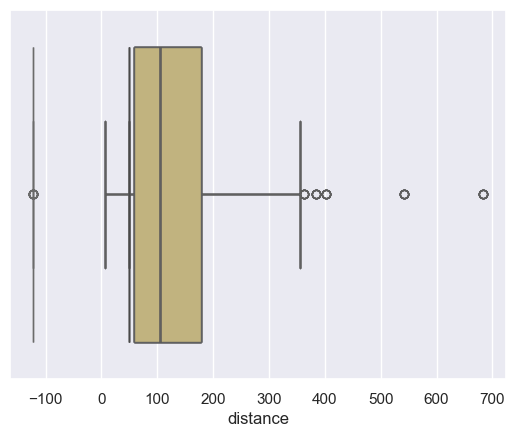

In [166]:
# Detecting Outliers
sns.boxplot(x=df_merged_dropped_columns['distance'])
plt.show()

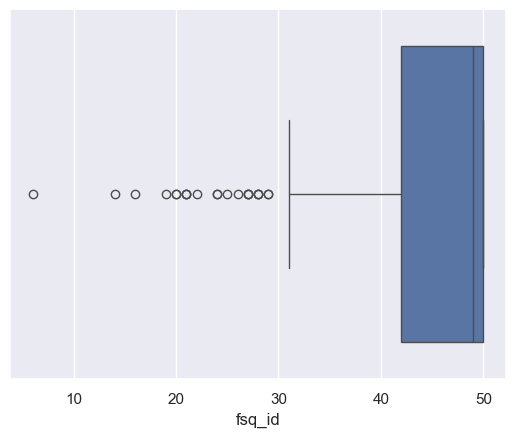

In [230]:
# Detecting Outliers
sns.boxplot(x=df_merged_dropped_columns['fsq_id'])
plt.show()

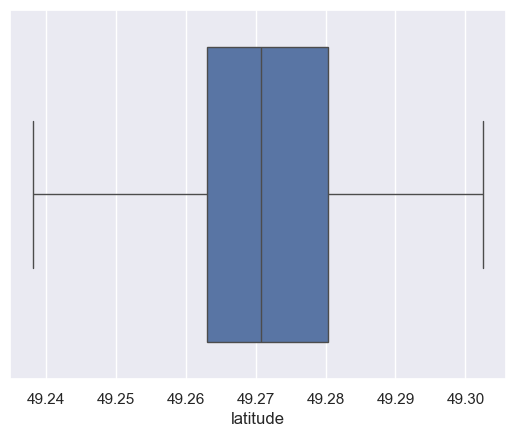

In [167]:
sns.boxplot(x=df_merged_dropped_columns['latitude'])
plt.show()

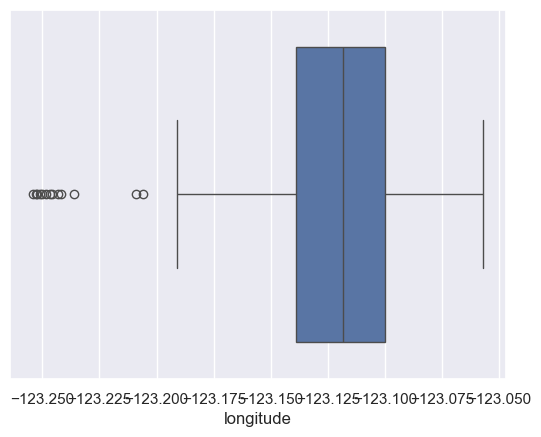

In [222]:
sns.boxplot(x=df_merged_dropped_columns['longitude'])
plt.show()

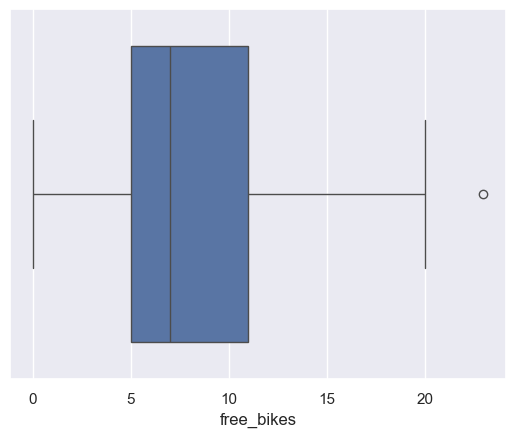

In [169]:
sns.boxplot(x=df_merged_dropped_columns['free_bikes'])
plt.show()

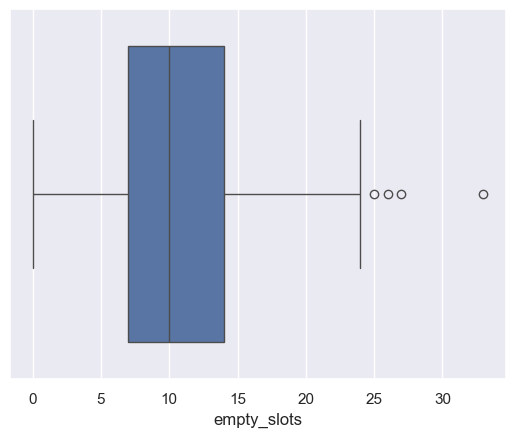

In [170]:
sns.boxplot(x=df_merged_dropped_columns['empty_slots'])
plt.show()

In [157]:
# view columns in dataframe
df_merged_dropped_columns.columns

Index(['bike_station_index', 'distance', 'fsq_id', 'id', 'stations',
       'latitude', 'longitude', 'free_bikes', 'empty_slots'],
      dtype='object')

In [190]:
# calculating quantile
# Q1 = df_merged_dropped_columns.quantile(0.25, numeric_only=True)
# Q3 = df_merged_dropped_columns.quantile(0.75, numeric_only=True)
# IQR = Q3 - Q1
# print(IQR)

## Scatter Diagram, Heat Maps and Histogram

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

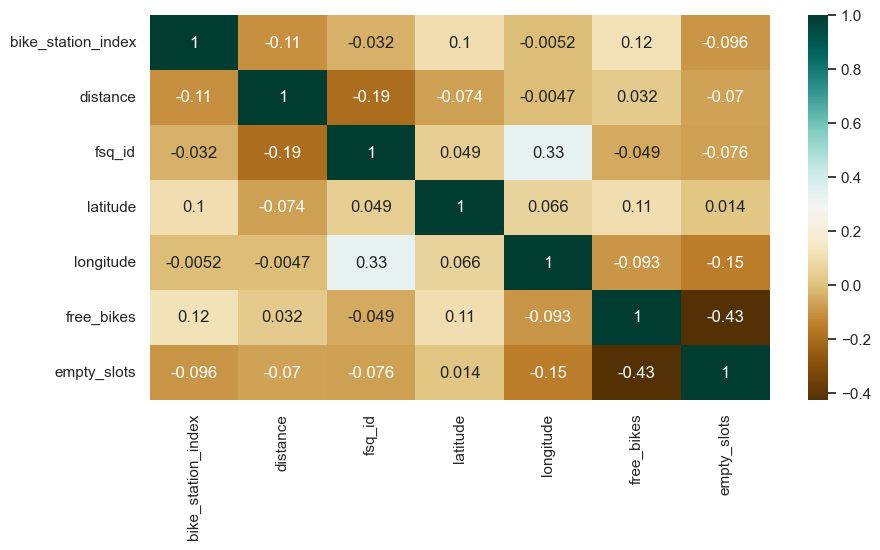

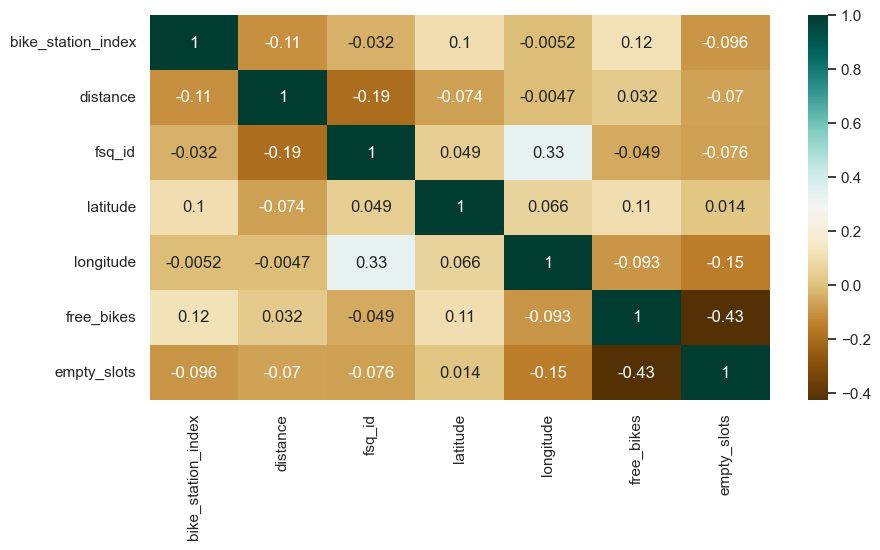

In [178]:
# Heat Maps
plt.figure(figsize=(10,5))
c= df_merged_dropped_columns.corr(numeric_only=True)
sns.heatmap(c,cmap="BrBG",annot=True)
c
plt.show()

The heat maps above shows low correlation between the variables (features)

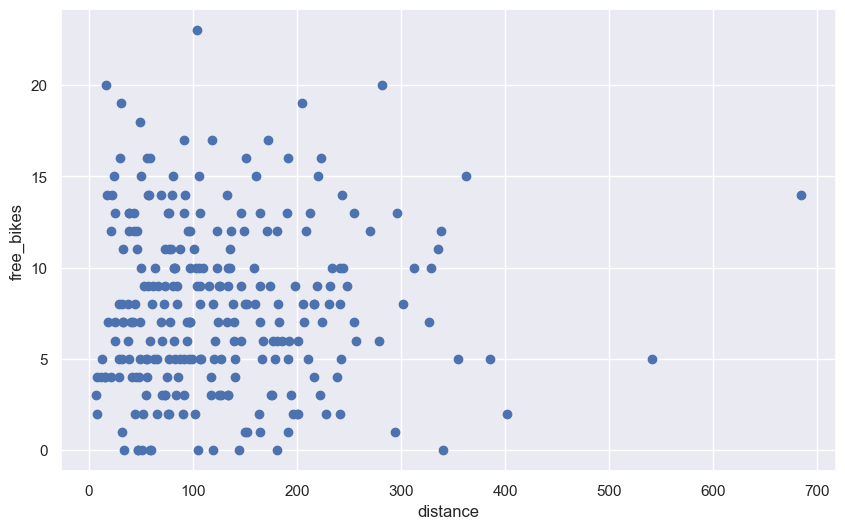

In [180]:
#Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_merged_dropped_columns['distance'], df_merged_dropped_columns['free_bikes'])
ax.set_xlabel('distance')
ax.set_ylabel('free_bikes')
plt.show()

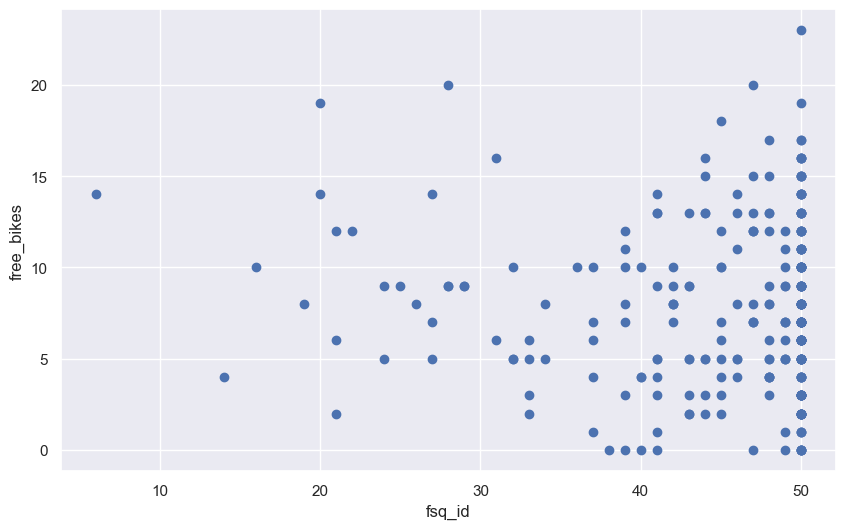

In [232]:
#Scatterplot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_merged_dropped_columns['fsq_id'], df_merged_dropped_columns['free_bikes'])
ax.set_xlabel('fsq_id')
ax.set_ylabel('free_bikes')
plt.show()

The scatter plot further supports the correlation results. Indicating no correlation exists between free rides and distance, as well as fsq_id

In [ ]:
# Dropping the duplicate rows
# df_merged_dropped_columns.to_csv('model_build.csv')

In [200]:
# import numpy
# import numpy as np
# import pandas as pd

# import linear_model and datasets from sklearn
# from sklearn import linear_model, datasets

In [191]:
#df_merged_dropped_columns.columns

In [183]:
# X = df_merged_dropped_columns[['distance', 'fsq_id']]
# y = df_merged_dropped_columns['free_bikes']

In [187]:
# df_merged_dropped_columns.to_csv('data_city_bikes')

In [184]:
# import statsmodels.api as sm

In [185]:
# X = sm.add_constant(X) # adding a constant
# lin_reg = sm.OLS(y,X)

In [192]:
# model = lin_reg.fit()
# print_model = model.summary()
# print(print_model)

In [214]:
# import numpy
# import numpy as np
# import pandas as pd

# import linear_model from sklearn
# from sklearn import linear_model, datasets

In [ ]:
# X = data[['distance', 'fsq_id']]
# y = df_merged_dropped_columns['free_bikes']

In [213]:
# data.to_csv('data_with_cat_group.csv')

In [231]:
# data.head()

In [228]:
# join the data 
#df_m = pd.merge(df_results, df_city_bikes,left_on='bike_station_index',right_on=df_city_bikes.index)
#df_m

In [227]:
# seperate the category names multiple columns to get the categorical codes for each category
#df_exploded = data('category_names')

# One-hot encode category names
#df_encoded = pd.get_dummies(df_exploded, columns=['category_names'])

# Aggregate back to the original dataframe (if needed)
#df_final = df_encoded.groupby(data.index).sum().reset_index()

#print(df_final)